In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [5]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_frame.loc[:, 1:] /= 255.0

In [7]:
tmp = data_frame.loc[1, :]

In [8]:
tmp[tmp != 0]

128    0.200000
129    0.623529
130    0.992157
131    0.623529
132    0.196078
155    0.188235
156    0.933333
157    0.988235
158    0.988235
159    0.988235
160    0.929412
182    0.211765
183    0.890196
184    0.992157
185    0.988235
186    0.937255
187    0.913725
188    0.988235
189    0.223529
190    0.023529
208    0.039216
209    0.235294
210    0.878431
211    0.988235
212    0.992157
213    0.988235
214    0.792157
215    0.329412
216    0.988235
217    0.992157
         ...   
577    0.874510
578    0.654902
579    0.219608
595    0.333333
596    0.988235
597    0.988235
598    0.988235
599    0.898039
600    0.843137
601    0.988235
602    0.988235
603    0.988235
604    0.768627
605    0.509804
623    0.109804
624    0.780392
625    0.988235
626    0.988235
627    0.992157
628    0.988235
629    0.988235
630    0.913725
631    0.568627
652    0.098039
653    0.501961
654    0.988235
655    0.992157
656    0.988235
657    0.552941
658    0.145098
Name: 1, Length: 176, dt

In [9]:
data=data_frame.as_matrix()

In [10]:
image=data[0,1:].reshape((28,28))

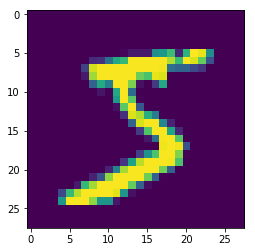

In [11]:
plt.imshow(image)
plt.show()

In [12]:
def show_image(data_matrix, index):
	image=data_matrix[index,1:].reshape((28,28))
	plt.imshow(image)
	plt.show()

In [13]:
data.shape

(60000, 785)

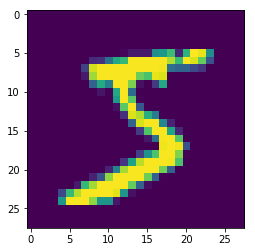

In [14]:
show_image(data, 0)

In [311]:
class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, learning_rate = 0.05, activation_functions = None):
        self.number_of_classes = 10
        self.train_data = train_data
        self.learning_rate = learning_rate
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(current_layer_num, next_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        
        self.bias_list = [np.random.randn(1, layer_num) for layer_num in self.neurons_num_per_layer[1:]]
        
    def main(self, batch_size):
        train_batches = self.create_train_batches(batch_size)
        self.feed_forward(train_batches)
        # TODO: finish
        
  
    def feed_forward(self, train_batches):
        for train_batch in train_batches:
            labels = np.transpose(self.one_hot_encoded(train_batch[:, 0:1]))
            train_batch_features = train_batch[:, 1:]
            layer_output = [train_batch_features]
            u = []
            for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                u.append(np.matmul(layer_output[-1], w) + b)
                layer_output.append(activation_function(u[-1]))
            
            print("aaa {0}".format(u[-1].shape))
            print("bbb {0}".format(self.softmax_derivative(u[-1]).shape))
            delta = [(layer_output[-1] - labels).T * self.softmax_derivative(u[-1])]
            for layer_num in reversed(range(1, self.layers_num - 1)):
                print("delta {0}".format(delta[-1].shape))
                print("weight_list {0}".format((self.weight_list[layer_num]).shape))
                print("u[layer_num] {0}".format(u[layer_num].shape))
                print("sigm_der {0}".format(self.sigmoid_derivative(u[layer_num]).shape))
                delta.append(np.matmul(self.weight_list[layer_num], delta[-1]) \
                             * self.sigmoid_derivative(u[layer_num]))
            delta = list(reversed(delta))
            
            grad_w = []
            grad_b = delta.copy()
            for activ, d, _u in zip(self.activation_functions, delta, u):
                grad_w.append(d * activ(_u).T)
            
            new_weight_list = [(w - self.learning_rate * gw) \
                               for w, gw in zip(self.weight_list, grad_w)]
            self.weight_list = new_weight_list
            
            new_bias_list = [ (b - self.learning_rate * gb) \
                             for b, gb in zip(self.bias_list, grad_b)]
            self.bias_list = new_bias_list
            
    def softmax_derivative(self, probabilities):
        probabilities = np.asarray(probabilities[0]).reshape(probabilities.shape[1])
        diff_output=np.zeros([self.number_of_classes, self.number_of_classes])
        for row in range (diff_output.shape[0]):
            for col in range (diff_output.shape[1]):
                if (col==row):
                    print("res {0}".format(probabilities[row]))
                    diff_output[col,row]=probabilities[row]*(1-probabilities[col])
                else:
                    diff_output[col,row]=-probabilities[row]*probabilities[col]
        return diff_output
                             
    def sigmoid_derivative(self, u):
        diff_output=u*(1-u)
        return diff_output
        
    def tanh_derivative(self, u):
        diff_output=1-(u)^2
        return diff_output
         
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        

In [312]:
net = Network(data[1:10], [2,3])

In [313]:
[matrix.shape for matrix in net.weight_list]

[(784, 2), (2, 3), (3, 10)]

In [314]:
net.input_neurons_num

784

In [315]:
net.weight_list

[array([[ 0.20438608,  0.15545747],
        [ 0.10487235,  0.55282862],
        [-1.34471012,  0.11914403],
        ...,
        [-0.63372406,  0.21820184],
        [-1.4111264 ,  1.23897305],
        [-0.02587423, -1.97079923]]),
 array([[-0.58189624,  0.10655305, -0.90973188],
        [ 2.11725494,  1.54761802,  0.5031853 ]]),
 array([[-0.75562923,  1.24322485,  0.80743515, -0.05979515, -0.1863865 ,
          0.02431888,  1.51202409,  1.01625835,  0.54879288, -2.40275221],
        [-0.65537247,  2.28276306, -0.69962793,  0.46493761, -0.60896599,
         -0.56763159,  1.00806413,  0.03744628,  1.18271655, -0.99063389],
        [-0.99203984,  0.20030638,  0.466503  , -0.97772002,  1.81269635,
         -0.74805912, -0.71578558,  0.51155473,  0.23017569, -2.30791329]])]

In [316]:
net.sigmoid_function(0)

0.5

In [317]:
[matrix.shape for matrix in net.create_train_batches(2)]

[(2, 785), (2, 785), (2, 785), (2, 785), (1, 785)]

In [318]:
np.argmax(net.softmax_function(np.array([1,2,3])))

2

In [319]:
net.softmax_function(np.array([1,2,3]))

array([0.09003057, 0.24472847, 0.66524096])

In [320]:
net.one_hot_encoded(np.array([1,2,3,4]))

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [321]:
net.main(1)

aaa (1, 10)
res -1.9151474158494164
res 3.5319608158864817
res -0.48447452277281455
res 0.47139872577210257
res 0.2809679005090782
res 0.5114854425714394
res 0.1535288989904786
res 0.7192657410900436
res 0.2308679698592495
res -4.402246385712147
bbb (10, 10)
res -1.9151474158494164
res 3.5319608158864817
res -0.48447452277281455
res 0.47139872577210257
res 0.2809679005090782
res 0.5114854425714394
res 0.1535288989904786
res 0.7192657410900436
res 0.2308679698592495
res -4.402246385712147
delta (10, 10)
weight_list (3, 10)
u[layer_num] (1, 10)
sigm_der (1, 10)
delta (3, 10)
weight_list (2, 3)
u[layer_num] (1, 3)
sigm_der (1, 3)


ValueError: operands could not be broadcast together with shapes (2,10) (1,3) 

In [310]:
net.neurons_num_per_layer

[784, 2, 3, 10]

In [ ]:
len(net.create_train_batches(2))

In [ ]:
net.back_propagation(net.feed_forward(2))

In [ ]:
net.train_data[:, 0:1]